In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, GlobalAveragePooling2D, Conv2D, MaxPool2D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import pair_confusion_matrix
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# Path to destination directory where we there are the subfolders
dest_dir = os.getcwd() + "/gdrive/My Drive/Colab Notebooks/Dissertation/Reorganised_binary/"

In [ ]:
train_path = dest_dir + 'train/'
valid_path = dest_dir + 'valid/'
test_path = dest_dir + 'test/'

In [ ]:
#rescaling images in range [-1;1]
train_batches = ImageDataGenerator(
    rescale=1./127.5 - 1
)

valid_batches = ImageDataGenerator(
    rescale=1./127.5 - 1
)

test_batches = ImageDataGenerator(
    rescale=1./127.5 - 1
)

In [ ]:
train_generator = train_batches.flow_from_directory(
    directory=train_path,
    target_size=(224,224),
    batch_size=32
)

valid_generator = valid_batches.flow_from_directory(
    directory=valid_path,
    target_size=(224,224),
    batch_size=32
)

test_generator = test_batches.flow_from_directory(
    directory=test_path,
    target_size=(224,224),
    batch_size=32
)

Found 1778 images belonging to 2 classes.
Found 224 images belonging to 2 classes.
Found 224 images belonging to 2 classes.


In [ ]:
MNV2model =  tf.keras.applications.MobileNetV2 (weights='imagenet', include_top = False)

x = MNV2model.output

x = GlobalAveragePooling2D()(x)

preds = Dense(2, activation = 'sigmoid')(x)

MNV2model=Model (inputs=MNV2model.input, outputs = preds)

In [ ]:
MNV2model.summary()

In [ ]:
for layers in MNV2model.layers[:-1]:
  layers.trainable = False

In [ ]:
MNV2model.summary()

In [ ]:
epochs = 20

optimizer = Adam(learning_rate = 0.0001)

m = tf.keras.metrics.SensitivityAtSpecificity(0.5)

n = tf.keras.metrics.SpecificityAtSensitivity(0.5)

MNV2model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics = ['accuracy', m, n])

MNV2model.fit(x=train_generator, validation_data = valid_generator, epochs = epochs)

Epoch 1/20
56/56 [==============================] - 116s 2s/step - loss: 0.8172 - accuracy: 0.4792 - sensitivity_at_specificity: 0.4229 - specificity_at_sensitivity: 0.4336 - val_loss: 0.7452 - val_accuracy: 0.4732 - val_sensitivity_at_specificity: 0.4330 - val_specificity_at_sensitivity: 0.3973
Epoch 2/20
56/56 [==============================] - 99s 2s/step - loss: 0.7105 - accuracy: 0.4961 - sensitivity_at_specificity: 0.4719 - specificity_at_sensitivity: 0.4747 - val_loss: 0.6947 - val_accuracy: 0.4866 - val_sensitivity_at_specificity: 0.4688 - val_specificity_at_sensitivity: 0.4955
Epoch 3/20
56/56 [==============================] - 111s 2s/step - loss: 0.6743 - accuracy: 0.5962 - sensitivity_at_specificity: 0.6451 - specificity_at_sensitivity: 0.6271 - val_loss: 0.6686 - val_accuracy: 0.6473 - val_sensitivity_at_specificity: 0.7232 - val_specificity_at_sensitivity: 0.6920
Epoch 4/20
56/56 [==============================] - 112s 2s/step - loss: 0.6540 - accuracy: 0.6547 - sensitivi

In [ ]:
# save the model and its weights to disk

save_dir = os.getcwd() + "/gdrive/My Drive/Colab Notebooks/Dissertation/My model/"
model_path = save_dir + 'MN V2_model'
MNV2model.save(model_path)

In [ ]:
# load the saved model from disk
MNV2model = load_model(model_path)

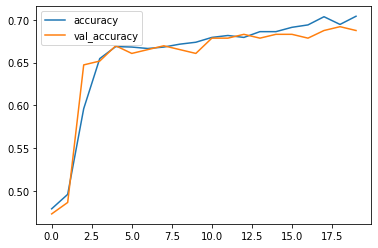

In [ ]:
losses = pd.DataFrame(MNV2model.history.history)
losses[['accuracy','val_accuracy']].plot()

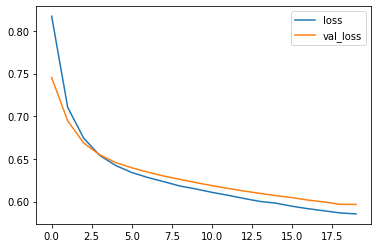

In [ ]:
losses[['loss','val_loss']].plot()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix


m = tf.keras.metrics.SensitivityAtSpecificity(0.5)

n = tf.keras.metrics.SpecificityAtSensitivity(0.5)

# initialize empty lists for storing predictions and true labels
all_preds = []
all_labels = []

# loop over all batches of images in the test set
for i in range(len(test_generator)):
    # get the next batch of images and true labels
    imgs, labels = next(test_generator)
    
    # make predictions for the batch and append them to the list of all predictions
    preds = MNV2model.predict(imgs)
    all_preds.append(preds)
    
    # append the true labels for the batch to the list of all labels
    all_labels.append(labels)

# concatenate the arrays of all predictions and all labels
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# get the predicted classes for all images in the test set
pred_classes = all_preds.argmax(axis=1)

# get the true classes for all images in the test set
true_classes = all_labels.argmax(axis=1)

# compute the accuracy, sensitivity, and specificity for the entire test set
acc = accuracy_score(true_classes, pred_classes)
sensitivity = m(all_labels, all_preds).numpy()
specificity = n(all_labels, all_preds).numpy()

# compute the confusion matrix for the entire test set
cm = confusion_matrix(true_classes, pred_classes)

print('Accuracy:', acc)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('Confusion matrix:\n', cm)

1/1 [==============================] - 1s 722ms/step
Accuracy: 0.7008928571428571
Sensitivity: 0.875
Specificity: 0.8526786
Confusion matrix:
 [[67 45]
 [22 90]]
